# Demo SSentiA_Sp model for CorpusCine dataset

This problem is to design an automated model for sentiment analysis in Spanish with no labels. Specifically we test our apporach in CorpusCine dataset, which is a dataset formed by 3878 Spanish-written movie reviews captured from the MuchoCine website (\url{https://muchocine.net/}). Each document is rated using an integer tag ranging from 1 (unpleasant movie) to 5 (excellent movie). We use a methodology to treat PaperReviews as a binary classification problem. Samples with rating one or two are considered as negatives reviews; similarly, documents with rating four or five are categorized as positive reviews. This dataset is publicy avilable in http://www.lsi.us.es/~fermin/corpusCine.zip.

# Part 1. Load Python Packages

## 1.1 Install the required packages

In [ ]:
!pip install pip setuptools wheel
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install deep-translator
!python -m pip install urllib3[secure]
!pip install spacytextblob
!pip install vaderSentiment
!python -m spacy download es_core_news_sm

## 1.2 Import packages

In [1]:
import pandas as pd
import numpy as np
import sys
import csv

sys.path.append('../Model')
from SSentiA_Sp import sSentiA_Sp
from urllib.request import urlopen
import json

# Part 2. Loading the data

## 2.1. load data

In [2]:
DataName = 'MoviesReview'

path = '../Data/' + DataName + '.xlsx'

Data = pd.read_excel(path)
numpy_array = Data.values
X = numpy_array[:,0]
Y = np.asarray(numpy_array[:,1])

## 2.2 Process the labels

Originally, such dataset configures a 5-class classification problem, we convert it into a binary problem as follows: First, we discard samples with label equal to three. Moreover, samples with labels one and two are assigned to negative class (0); on the other hand, samples with labels four and fiv are categorized a positives (1)

In [3]:
X = X[Y != 3]
Y = Y[Y != 3]
Y[Y < 3] = 0
Y[Y > 3] = 1

# Part 3. Applying lexicon-based approaches to CorpusCine dataset

## 3.1 Textblob lexicon

In [9]:
from LRsentiA_TextBlob import LexicalAnalyzer
r = LexicalAnalyzer('PaperReview')
predictions, pred_confidence_scores = r.classify_binary_dataset(X,Y)

Prediction ------
---- 0.6975 0.5828 0.635 0.5939


## 3.2 VADER lexicon

In [10]:
from LRsentiA_VADER import LexicalAnalyzer
r = LexicalAnalyzer('PaperReview')
predictions, pred_confidence_scores = r.classify_binary_dataset(X,Y)

Prediction ------
---- 0.5966 0.5685 0.5822 0.5764


## 3.3 Spanish lexicon

In [11]:
from LRSentiA_Spanish import LexicalAnalyzer
r = LexicalAnalyzer('PaperReview')
predictions, pred_confidence_scores = r.classify_binary_dataset(X,Y)

Prediction ------
---- 0.555 0.5547 0.5549 0.5558


# Part 3. Our hybrid approach

Accordingly, in this work, we employ a self-supervised approach based on the Self-supervised Sentiment Analyzer for classification from unlabeled data--(SSentiA) . Such an approach generates pseudo-labels using a lexicon-based method; then, these labels are enhanced using a supervised classification scheme.

## 3.1 No labels

We first test our approach under the scenario of having no labels.

In [4]:
from LRsentiA_Sp import LexicalAnalyzer
r = LexicalAnalyzer('PaperReview')
predictions, pred_confidence_scores = r.classify_binary_dataset(X,Y)
df1, df2, df3, df4, df5 = r.distribute_predictions_into_bins(X,Y,predictions, pred_confidence_scores)

---- 0.6416 0.636 0.6388 0.6389
$$$$
0.24068406293379518 0.3336704252818985
Bin Threshold 0.3336704252818985 0.24068406293379518 0.1476977005856919 0.0001
---->>>  2625 2625


In [5]:
s = sSentiA_Sp()
s.apply_SSSentiA(df1, df2, df3, df4, df5)

--- 1102
..
Bin-3 Results
Total:  0.6144 0.604 0.6092 0.6097
..
Bin-4results
F1:  0.6262 0.6222 0.6242 0.6163
Bin 5 results
F1:  0.5932 0.5847 0.5889 0.5724

Overall Predcition of SSSentiA
Overall:  0.6564 0.6472 0.6518 0.6507


## 3.2 Few labels

Finally, aiming to evaluate the behavior of our hybrid proposal in scenarios with limited labeled data, we carry out an additional experiment, where we vary the number of labels.

In [6]:
from supervisedalgorithm import Logistic_Regression_Classifier, SVM_Classifier

from supervisedalgorithm import  Performance
from supervisedalgorithm  import TF_IDF

from sklearn.model_selection import train_test_split
from random import randint

In [7]:
df = [df1, df2, df3, df4, df5]

X  = np.array([1])
Sc = np.array([1])
Y  = np.array([1]) #true labels
Z  = np.array([1])

for i in range(5):
    data = df[i]
    content = data.values
    X = np.concatenate((X, content[:,0]))
    Sc = np.concatenate((Sc, content[:,3]))
    Y = np.concatenate((Y, content[:,1]))
    Z = np.concatenate((Z, content[:,2]))

X, Sc, Y, Z = X[1:], Sc[1:], Y[1:], Z[1:]
Y = Y.astype('int')
Z = Z.astype('int')

P = np.arange(0.05,0.9,0.1)
N = len(P)
Cla = ['LR', 'SVM']
Data_1 = []
for cl in Cla:
    if cl == 'LR':
        ml_classifier = Logistic_Regression_Classifier() 
    else:
        ml_classifier = SVM_Classifier()
    mean_F1 = np.zeros(N)
    min_F1 = np.zeros(N)
    max_F1 = np.zeros(N)
    std_F1 = np.zeros(N)
    for j, p in enumerate(P):
        aux_F1 = np.zeros(5)
        for i in range(5):
            X_true, X_, _, Sc_, y_true, y_, _, Z_ = train_test_split(X, Sc, Y, Z, test_size=1-p, random_state=randint(100, 1000))
            X1, Y1, Z1, X2, Y2, Z2, X3, Y3, Z3, X4, Y4, Z4, X5, Y5, Z5 = LexicalAnalyzer('PaperReview').distribute_predictions_into_bins_1(X_, y_, Z_, Sc_)
            
            X1 = np.concatenate((X_true, X1))
            Y1 = np.concatenate((y_true, Y1))
            Z1 = np.concatenate((y_true, Z1))
            
            bin_size_1_2 = len(X1) + len(X2) # + len(X_3) #+  len(X_01) + len(X_02) + len( X_11) + len(X_12)
            print("---",bin_size_1_2)
            
            
            data = np.concatenate((X1,X2,X3), axis=None)
            label = np.concatenate((Z1,Z2,Y3), axis=None)
            
            tf_idf = TF_IDF()
            data = tf_idf.get_tf_idf(data)
            
            X_train = data[:bin_size_1_2]
            Y_train = label[:bin_size_1_2]
            
            X_test = data[bin_size_1_2:]
            Y_test = label[bin_size_1_2:]
            
            prediction_bin_3 = ml_classifier.predict(X_train, Y_train, X_test)
    
            print("Bin-3 Results")
            performance = Performance()
            _,precision,  recall, f1_score, acc = performance.get_results(Y_test, prediction_bin_3)
            print("Total: ", round(precision,4),  round(recall,4), round(f1_score,4),round(acc,4) )

            data = np.concatenate((X1,X2,X3,X4,X5), axis=None)
            label = np.concatenate((Z1,Z2,prediction_bin_3,Y4,Y5), axis=None)
            
            
            tf_idf = TF_IDF()
            data = tf_idf.get_tf_idf(data)
        
            bin_1_2_3_training_data = len(X1) + len(X2) + len(X3)  
            
            X_train = data[:bin_1_2_3_training_data]
            Y_train = label[:bin_1_2_3_training_data]
            
            X_test = data[bin_1_2_3_training_data:]
            Y_test = label[bin_1_2_3_training_data:]
    
 
            print("Bin-4results")
            prediction_bin_4_5 = ml_classifier.predict(X_train, Y_train, X_test)
            _,precision,  recall, f1_score, acc = performance.get_results(Y_test[:len(X4)], prediction_bin_4_5[:len(X4)])
            print("F1: ", round(precision,4),  round(recall,4), round(f1_score,4),round(acc,4) )
            aux_F1[i] = acc
            
        mean_F1[j] = np.mean(aux_F1)
        std_F1[j] = np.std(aux_F1)
        min_F1[j] = mean_F1[j] - 2*np.std(aux_F1)
        max_F1[j] = mean_F1[j] + 2*np.std(aux_F1)
        
    Data_ = np.concatenate((P.reshape(N,1), mean_F1.reshape(N,1), max_F1.reshape(N,1), min_F1.reshape(N,1)), axis=1)
    Dat = pd.DataFrame(Data_,columns =None, index=None)
    Data_1.append([P.reshape(N,1), mean_F1.reshape(N,1), std_F1.reshape(N,1)])
#     Name_ = cl + '_Paper.dat'
#     Dat.to_csv(Name_,index=False, header=False,sep = " ")

$$$$
0.2398393714061324 0.33270391043404635
Bin Threshold 0.33270391043404635 0.2398393714061324 0.14697483237821846 0.0001
---->>>  2494 2494
--- 1176
..
Bin-3 Results
Total:  0.6585 0.647 0.6527 0.6547
..
Bin-4results
F1:  0.6485 0.645 0.6468 0.6392
$$$$
0.24043091566593303 0.3335110361595828
Bin Threshold 0.3335110361595828 0.240430915665933 0.14735079517228325 0.0001
---->>>  2494 2494
--- 1176
..
Bin-3 Results
Total:  0.6454 0.63 0.6376 0.6364
..
Bin-4results
F1:  0.6503 0.6422 0.6462 0.6331
$$$$
0.24025757938034947 0.3329232397640671
Bin Threshold 0.3329232397640671 0.24025757938034945 0.14759191899663177 0.0001
---->>>  2494 2494
--- 1169
..
Bin-3 Results
Total:  0.6688 0.6594 0.664 0.6632
..
Bin-4results
F1:  0.6534 0.6513 0.6524 0.6472
$$$$
0.24023915395664905 0.3335072771694056
Bin Threshold 0.3335072771694056 0.24023915395664902 0.14697103074389248 0.0001
---->>>  2494 2494
--- 1173
..
Bin-3 Results
Total:  0.6549 0.6432 0.649 0.6463
..
Bin-4results
F1:  0.6693 0.6648 0.667 

Bin-3 Results
Total:  0.8418 0.8418 0.8418 0.8418
..
Bin-4results
F1:  0.8248 0.825 0.8249 0.8252
$$$$
0.24206655799788418 0.3335824382122551
Bin Threshold 0.3335824382122551 0.2420665579978842 0.15055067778351333 0.0001
---->>>  919 919
--- 2100
..
Bin-3 Results
Total:  0.794 0.7874 0.7907 0.7925
..
Bin-4results
F1:  0.786 0.7881 0.7871 0.7873
$$$$
0.23672446089068697 0.3276197581315545
Bin Threshold 0.3276197581315545 0.23672446089068694 0.14582916364981943 0.0001
---->>>  919 919
--- 2095
..
Bin-3 Results
Total:  0.8512 0.8511 0.8512 0.8512
..
Bin-4results
F1:  0.7969 0.7965 0.7967 0.7948
$$$$
0.2519496775952191 0.3476021180124136
Bin Threshold 0.3476021180124136 0.2519496775952191 0.15629723717802455 0.0001
---->>>  657 657
--- 2243
..
Bin-3 Results
Total:  0.7992 0.8003 0.7998 0.8027
..
Bin-4results
F1:  0.835 0.8349 0.835 0.835
$$$$
0.2423042893748118 0.3348934035817775
Bin Threshold 0.3348934035817775 0.2423042893748118 0.1497151751678461 0.0001
---->>>  657 657
--- 2255
..
Bin-

Bin-3 Results
Total:  0.8119 0.807 0.8094 0.8074
..
Bin-4results
F1:  0.7812 0.7819 0.7815 0.7794
$$$$
0.23510721223528494 0.326073999759763
Bin Threshold 0.326073999759763 0.23510721223528497 0.14414042471080693 0.0001
---->>>  1444 1444
--- 1782
..
Bin-3 Results
Total:  0.776 0.7763 0.7761 0.7773
..
Bin-4results
F1:  0.8193 0.8198 0.8196 0.8194
$$$$
0.23953918963917598 0.33111099429733026
Bin Threshold 0.33111099429733026 0.239539189639176 0.14796738498102174 0.0001
---->>>  1444 1444
--- 1786
..
Bin-3 Results
Total:  0.7824 0.7789 0.7807 0.7802
..
Bin-4results
F1:  0.7981 0.7991 0.7986 0.798
$$$$
0.24233551099055042 0.3351733678815966
Bin Threshold 0.3351733678815966 0.24233551099055042 0.14949765409950427 0.0001
---->>>  1444 1444
--- 1793
..
Bin-3 Results
Total:  0.8247 0.8233 0.824 0.8235
..
Bin-4results
F1:  0.7884 0.7895 0.789 0.7901
$$$$
0.24275356072082732 0.33379950456780166
Bin Threshold 0.33379950456780166 0.24275356072082732 0.15170761687385295 0.0001
---->>>  1444 1444
-

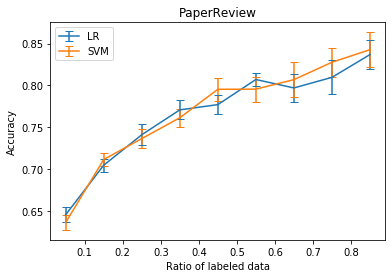

In [8]:
import matplotlib.pyplot as plt
for i in range(2):
    plt.errorbar(Data_1[i][0].flatten(), Data_1[i][1].flatten(), yerr=Data_1[i][2].flatten(),capsize=4)
plt.legend(['LR', 'SVM'])
plt.title('PaperReview')
plt.ylabel('Accuracy')
plt.xlabel('Ratio of labeled data')
plt.show()